In [28]:
import pandas as pd
import numpy as np
from string import whitespace, ascii_letters
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import os
import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19
from time import sleep
from IPython.display import display, Image as IPImage
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing import image as keras_image
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from PIL import Image
import tensorflow as tf
from transformers import pipeline, AutoTokenizer, TFAutoModelForQuestionAnswering

from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

### 1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

In [2]:
df = pd.read_csv('ukr.txt', delimiter='\t', header=None)
print(f'Dataset size: {df.shape}')
df.head(15)

Dataset size: (13955, 3)


,0,1,2
0,Go.,Йди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Вітаю!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Привіт.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Hi.,Привіт!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Run!,Біжіть!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
5,Run!,Тікайте!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
6,Run!,Біжи!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
7,Wow!,Оце так!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
8,Wow!,Клас!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
9,Wow!,Класно!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [3]:
words = df.drop(2, axis=1)
words.rename(columns={0: "eng", 1: "ukr"},inplace=True)
words.head(15)

,eng,ukr
0,Go.,Йди.
1,Hi.,Вітаю!
2,Hi.,Привіт.
3,Hi.,Привіт!
4,Run!,Біжіть!
5,Run!,Тікайте!
6,Run!,Біжи!
7,Wow!,Оце так!
8,Wow!,Клас!
9,Wow!,Класно!


In [4]:
ukr_letters =  u"абвгґдеєжзиіїйклмнопрстуфхцчшщьюяАБВГҐДЕЄЖЗИІЇЙКЛМНОПРСТУФХЦЧШЩЬЮЯ"
all_letters = ukr_letters + whitespace + ascii_letters

In [5]:
def text_preprocessing(text):
    word = "".join([i for i in text if i in all_letters])
    return word.lower()

#### Text preprocessing

In [6]:
words["eng"]= words["eng"].apply(text_preprocessing)
words["ukr"]=words["ukr"].apply(text_preprocessing)
words = words.drop_duplicates()
words.head(15)

,eng,ukr
0,go,йди
1,hi,вітаю
2,hi,привіт
4,run,біжіть
5,run,тікайте
6,run,біжи
7,wow,оце так
8,wow,клас
9,wow,класно
10,wow,ого


#### Tokenization

##### English 

In [7]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(words['eng'].values)
eng_processed, eng_tokenizer = eng_tokenizer.texts_to_sequences(words['eng'].values), eng_tokenizer
eng_processed = pad_sequences(eng_processed, maxlen=None, padding='post')

eng_sentence_length = max(len(seq) for seq in eng_processed)
eng_vocabulary_size = len(eng_tokenizer.word_index)


print("The biggest English sentence:", eng_sentence_length)
print("English vocabulary size:", eng_vocabulary_size)

The biggest English sentence: 6
English vocabulary size: 2552


##### Ukrainian

In [8]:
ukr_tokenizer = Tokenizer()
ukr_tokenizer.fit_on_texts(words['ukr'].values)
ukr_processed, ukr_tokenizer = ukr_tokenizer.texts_to_sequences(words['ukr'].values), ukr_tokenizer

ukr_processed = pad_sequences(ukr_processed, maxlen=None, padding='post')
ukr_processed = ukr_processed.reshape(*ukr_processed.shape, 1)

ukr_sentence_length = max(len(seq) for seq in ukr_processed)
ukr_sequences_padded = pad_sequences(ukr_processed, maxlen=ukr_sentence_length, padding='post')

ukr_vocabulary_size = len(ukr_tokenizer.word_index)

print("The biggest Ukrainian sentence", ukr_sentence_length)
print("Ukraine vocabulary size:", ukr_vocabulary_size)

The biggest Ukrainian sentence 9
Ukraine vocabulary size: 6226


#### Sequential model

In [9]:
model = Sequential()

model.add(Embedding(eng_vocabulary_size+1, 128, input_length=eng_sentence_length, input_shape=eng_processed.shape[1:]))
# Encoder
model.add(Bidirectional(LSTM(128)))
model.add(RepeatVector(ukr_sentence_length))
# Decoder
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(ukr_vocabulary_size+1, activation='softmax')))
model.compile(loss=sparse_categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])
model.summary()
model.fit(eng_processed, ukr_processed, batch_size=64, epochs=100, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 128)            326784    
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 repeat_vector (RepeatVecto  (None, 9, 256)            0         
 r)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 9, 256)            394240    
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 9, 512)            131584    
 ributed)                                               

In [10]:
# Preprocess the sentences outside the loop
sentences = ['he began to run', 'give me a spoon', 'come if you can']
sentence_sequences = [eng_tokenizer.texts_to_sequences([sentence])[0] for sentence in sentences]
sentence_sequences_padded = pad_sequences(sentence_sequences, maxlen=eng_processed.shape[-1], padding='post')

# Predict sequences for all input sentences in a batch
predicted_sequences = model.predict(sentence_sequences_padded)

# Mapping index to word for Ukrainian tokenizer
id_to_word_ukr = {value: key for key, value in ukr_tokenizer.word_index.items()}
id_to_word_ukr[0] = '<pad>'

# Decode and print the predicted sequences
for prediction in predicted_sequences:
    predicted_words = [id_to_word_ukr[np.argmax(pred)] for pred in prediction]
    print(' '.join(predicted_words))


1/1 [==============================] - 1s 530ms/step
він побіг <pad> <pad> <pad> <pad> <pad> <pad> <pad>
дай мені <pad> <pad> <pad> <pad> <pad> <pad> <pad>
ні я <pad> <pad> <pad> <pad> <pad> <pad> <pad>


2. Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

In [11]:
# Sentence sentiment analysis
classifier = pipeline('sentiment-analysis')

sentence1= 'The food at that restaurant was terrible'
sentence2= 'The weather today is absolutely beautiful'

print(f'result #1: {classifier(sentence1)}')
print(f'result #2: {classifier(sentence2)}')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


result #1: [{'label': 'NEGATIVE', 'score': 0.9996716976165771}]
result #2: [{'label': 'POSITIVE', 'score': 0.9998865127563477}]


In [12]:
tokenizer = AutoTokenizer.from_pretrained("robinhad/ukrainian-qa")
model = TFAutoModelForQuestionAnswering.from_pretrained("robinhad/ukrainian-qa", from_pt=True)

qa_model = pipeline("question-answering", model=model, tokenizer=tokenizer)

question = "Чому цей фільм такий відомий?"
context = "Цей фільм відомий своєю цікавою сюжетною лінією та акторською грою."
qa_model(question=question, context=context)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForQuestionAnswering: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForQuestionAnswering for predictions without further training.


{'score': 0.8336955904960632,
 'start': 17,
 'end': 67,
 'answer': ' своєю цікавою сюжетною лінією та акторською грою.'}

3. Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [40]:
# Constants
base_image_path = "cat.jpeg"
style_reference_image_path = "ornament.jpeg"
result_prefix = "stylizied_photo"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [41]:
# Image dimensions
img_nrows = 400
width, height = cv2.imread(base_image_path).shape[1], cv2.imread(base_image_path).shape[0]
img_ncols = int(width * img_nrows / height)

In [42]:
# Functions for preprocessing and deprocessing images
def preprocess_image(image_path):
    img = cv2.resize(cv2.imread(image_path), (img_ncols, img_nrows))
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Functions for loss calculation
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [43]:
# Model setup
model = vgg19.VGG19(weights='imagenet', include_top=False)
outputs_dict = {layer.name: layer.output for layer in model.layers}
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

In [44]:
# Loss computation
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [46]:
# Optimization setup
optimizer = tf.keras.optimizers.legacy.SGD(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

In [47]:
# Image preprocessing
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 50
for i in range(1, iterations + 1):
    print(i)
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    
    if i % 10 == 0:
        print("10s pause")
        sleep(10)
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = np.squeeze(deprocess_image(combination_image.numpy()), axis=0)
        fname = result_prefix + "_%d.png" % i
        tf.keras.utils.save_img(fname, img)

1
2
3
4
5
6
7
8
9
10
10s pause
Iteration 10: loss=496007.59
11
12
13
14
15
16
17
18
19
20
10s pause
Iteration 20: loss=313761.69
21
22
23
24
25
26
27
28
29
30
10s pause
Iteration 30: loss=297955.44
31
32
33
34
35
36
37
38
39
40
10s pause
Iteration 40: loss=284903.12
41
42
43
44
45
46
47
48
49
50
10s pause
Iteration 50: loss=250707.20


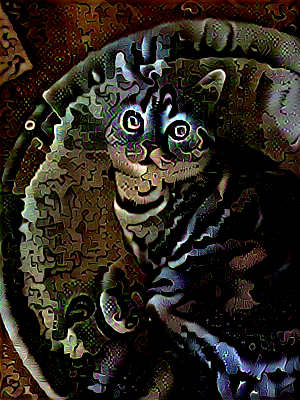

In [51]:
# Display final stylized image
display(IPImage('stylizied_photo_50.png'))